# User Clustering Model

This notebook creates a KMeans clustering model to group users into behavioral segments based on their wellness app usage patterns.

**Clustering Features:**
- `session_count`: Number of sessions
- `avg_session_duration`: Average session duration (minutes)
- `streak_length`: Current streak length (days)
- `preferred_time_of_day`: Encoded time preference (0=morning, 1=afternoon, 2=evening)
- `content_engagement_rate`: Rate of content engagement (0-1)
- `notification_response_rate`: Response rate to notifications (0-1)

The trained model will be saved as `kmeans_model.joblib` for use by the application.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to build user clustering model...")

Libraries imported successfully!
Ready to build user clustering model...


In [2]:
# Load the training dataset
data_path = "../data/training_dataset.csv"

if not os.path.exists(data_path):
    print("❌ Training dataset not found!")
    print("Please run the data_creation.ipynb notebook first to generate the dataset.")
else:
    df = pd.read_csv(data_path)
    print(f"✅ Loaded dataset with {len(df):,} users")
    print(f"Dataset shape: {df.shape}")
    display(df.head())

✅ Loaded dataset with 2,000 users
Dataset shape: (2000, 14)


,user_id,user_type,session_count,avg_session_duration,streak_length,preferred_time_of_day,content_engagement_rate,notification_response_rate,days_since_signup,total_sessions,last_login_days_ago,content_completion_rate,goal_progress_percentage,churn
0,user_0000,active,21,17.558516,19,2,0.872892,0.738740,151,39,2,0.714521,90.316165,0
1,user_0001,active,22,15.810662,25,1,0.852700,0.875421,221,42,0,0.776061,78.366475,0
2,user_0002,active,15,14.297296,14,2,0.759624,0.814070,80,58,2,0.945808,76.336701,0
3,user_0003,active,21,10.046289,11,1,0.932110,0.886253,271,29,1,0.724418,83.948156,0
4,user_0004,active,21,15.319960,12,2,0.660678,0.656424,79,60,1,0.806289,67.277958,0


In [3]:
# Prepare clustering features (exactly as defined in FeaturePreparator)
clustering_features = [
    'session_count',
    'avg_session_duration', 
    'streak_length',
    'preferred_time_of_day',
    'content_engagement_rate',
    'notification_response_rate'
]

X_cluster = df[clustering_features].copy()

print("Clustering features:")
for i, feature in enumerate(clustering_features, 1):
    print(f"  {i}. {feature}")

print(f"\nFeature matrix shape: {X_cluster.shape}")
print("\nFeature statistics:")
display(X_cluster.describe())

Clustering features:
  1. session_count
  2. avg_session_duration
  3. streak_length
  4. preferred_time_of_day
  5. content_engagement_rate
  6. notification_response_rate

Feature matrix shape: (2000, 6)

Feature statistics:


,session_count,avg_session_duration,streak_length,preferred_time_of_day,content_engagement_rate,notification_response_rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,12.144500,8.688296,7.934000,1.000500,0.514285,0.430955
std,8.119703,5.033791,8.172028,0.817823,0.246165,0.249685
min,1.000000,1.001665,0.000000,0.000000,0.050003,0.000127
25%,6.000000,4.593774,1.000000,0.000000,0.315801,0.223733
50%,10.000000,8.231628,5.000000,1.000000,0.531961,0.421661
75%,19.000000,11.760867,11.000000,2.000000,0.702264,0.623230
max,29.000000,19.978399,29.000000,2.000000,0.949170,0.898490


In [4]:
# Scale the features for better clustering
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print(f"Features scaled successfully!")
print(f"Scaled features shape: {X_cluster_scaled.shape}")

# Display scaling info
scaling_info = pd.DataFrame({
    'feature': clustering_features,
    'mean': scaler.mean_,
    'std': scaler.scale_
})
print("\nScaling parameters:")
display(scaling_info)

Features scaled successfully!
Scaled features shape: (2000, 6)

Scaling parameters:


,feature,mean,std
0,session_count,12.144500,8.117673
1,avg_session_duration,8.688296,5.032532
2,streak_length,7.934000,8.169984
3,preferred_time_of_day,1.000500,0.817618
4,content_engagement_rate,0.514285,0.246104
5,notification_response_rate,0.430955,0.249623


Testing different numbers of clusters...
k=2: Inertia=5418.19, Silhouette=0.474
k=3: Inertia=4201.86, Silhouette=0.336
k=2: Inertia=5418.19, Silhouette=0.474
k=3: Inertia=4201.86, Silhouette=0.336
k=4: Inertia=3716.82, Silhouette=0.288
k=4: Inertia=3716.82, Silhouette=0.288
k=5: Inertia=3102.24, Silhouette=0.292
k=5: Inertia=3102.24, Silhouette=0.292
k=6: Inertia=2704.48, Silhouette=0.297
k=6: Inertia=2704.48, Silhouette=0.297
k=7: Inertia=2409.52, Silhouette=0.296
k=7: Inertia=2409.52, Silhouette=0.296
k=8: Inertia=2241.71, Silhouette=0.294
k=8: Inertia=2241.71, Silhouette=0.294
k=9: Inertia=2095.41, Silhouette=0.294
k=9: Inertia=2095.41, Silhouette=0.294
k=10: Inertia=1953.37, Silhouette=0.286
k=10: Inertia=1953.37, Silhouette=0.286


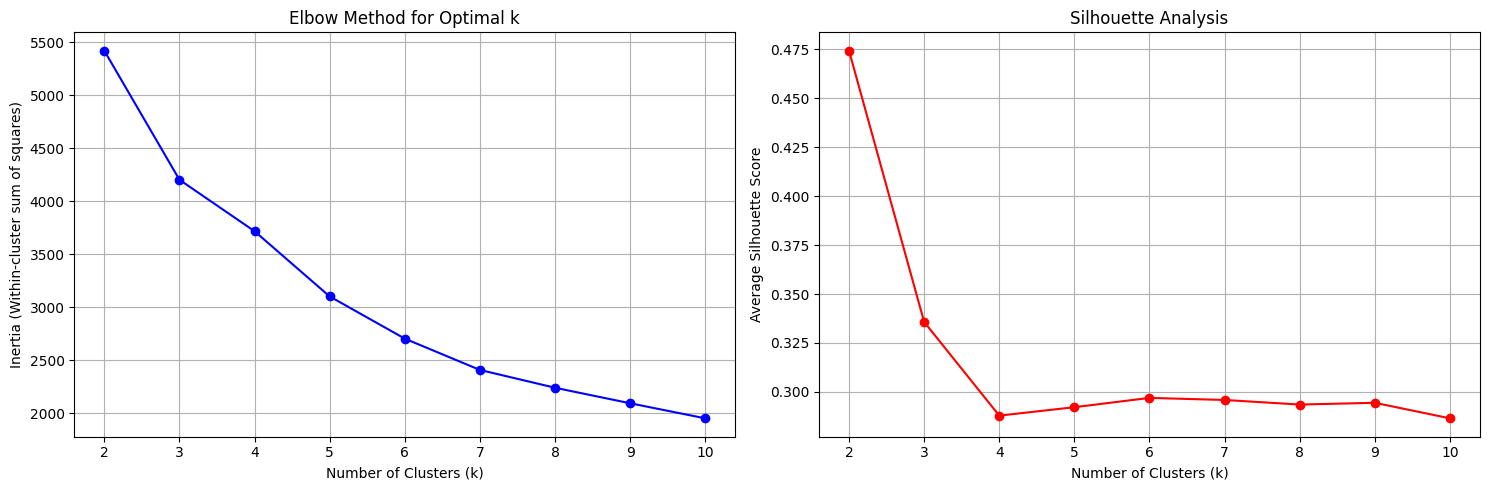


🎯 Optimal number of clusters based on silhouette score: 2


In [5]:
# Determine optimal number of clusters using multiple methods
K_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_cluster_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.3f}")

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow method
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette analysis
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Average Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Optimal number of clusters based on silhouette score: {optimal_k}")

In [6]:
# Train final KMeans model with optimal clusters (or use 3 for consistency)
n_clusters = 3  # Use 3 clusters to match existing application structure

print(f"Training KMeans model with {n_clusters} clusters...")

kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels

print(f"✅ KMeans model trained successfully!")
print(f"Inertia: {kmeans_final.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(X_cluster_scaled, cluster_labels):.3f}")

print("\nCluster distribution:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Cluster {cluster_id}: {count:,} users ({percentage:.1f}%)")

Training KMeans model with 3 clusters...
✅ KMeans model trained successfully!
Inertia: 4201.86
Silhouette Score: 0.336

Cluster distribution:
  Cluster 0: 614 users (30.7%)
  Cluster 1: 694 users (34.7%)
  Cluster 2: 692 users (34.6%)
✅ KMeans model trained successfully!
Inertia: 4201.86
Silhouette Score: 0.336

Cluster distribution:
  Cluster 0: 614 users (30.7%)
  Cluster 1: 694 users (34.7%)
  Cluster 2: 692 users (34.6%)


In [7]:
# Analyze clusters - compute mean values for each feature
print("=== Cluster Analysis ===")

cluster_analysis = df.groupby('cluster')[clustering_features + ['user_type']].agg({
    'session_count': 'mean',
    'avg_session_duration': 'mean',
    'streak_length': 'mean', 
    'preferred_time_of_day': 'mean',
    'content_engagement_rate': 'mean',
    'notification_response_rate': 'mean',
    'user_type': lambda x: x.mode()[0] if len(x) > 0 else 'unknown'  # Most common user type
})

# Round numeric columns for better readability
numeric_cols = ['session_count', 'avg_session_duration', 'streak_length', 
                'preferred_time_of_day', 'content_engagement_rate', 'notification_response_rate']
cluster_analysis[numeric_cols] = cluster_analysis[numeric_cols].round(2)

print("\nCluster characteristics:")
display(cluster_analysis)

# Decode preferred time for better interpretation
time_mapping = {0: 'Morning', 1: 'Afternoon', 2: 'Evening'}
print("\nPreferred time decoding:")
for cluster_id in range(n_clusters):
    avg_time = cluster_analysis.loc[cluster_id, 'preferred_time_of_day']
    decoded_time = time_mapping[round(avg_time)]
    print(f"  Cluster {cluster_id}: {decoded_time} (avg: {avg_time:.2f})")

=== Cluster Analysis ===

Cluster characteristics:


,session_count,avg_session_duration,streak_length,preferred_time_of_day,content_engagement_rate,notification_response_rate,user_type
cluster,,,,,,,
0,4.12,3.44,1.03,1.00,0.23,0.15,low_engagement
1,21.88,14.08,16.99,0.97,0.78,0.71,active
2,9.49,7.94,4.98,1.03,0.51,0.40,moderate



Preferred time decoding:
  Cluster 0: Afternoon (avg: 1.00)
  Cluster 1: Afternoon (avg: 0.97)
  Cluster 2: Afternoon (avg: 1.03)


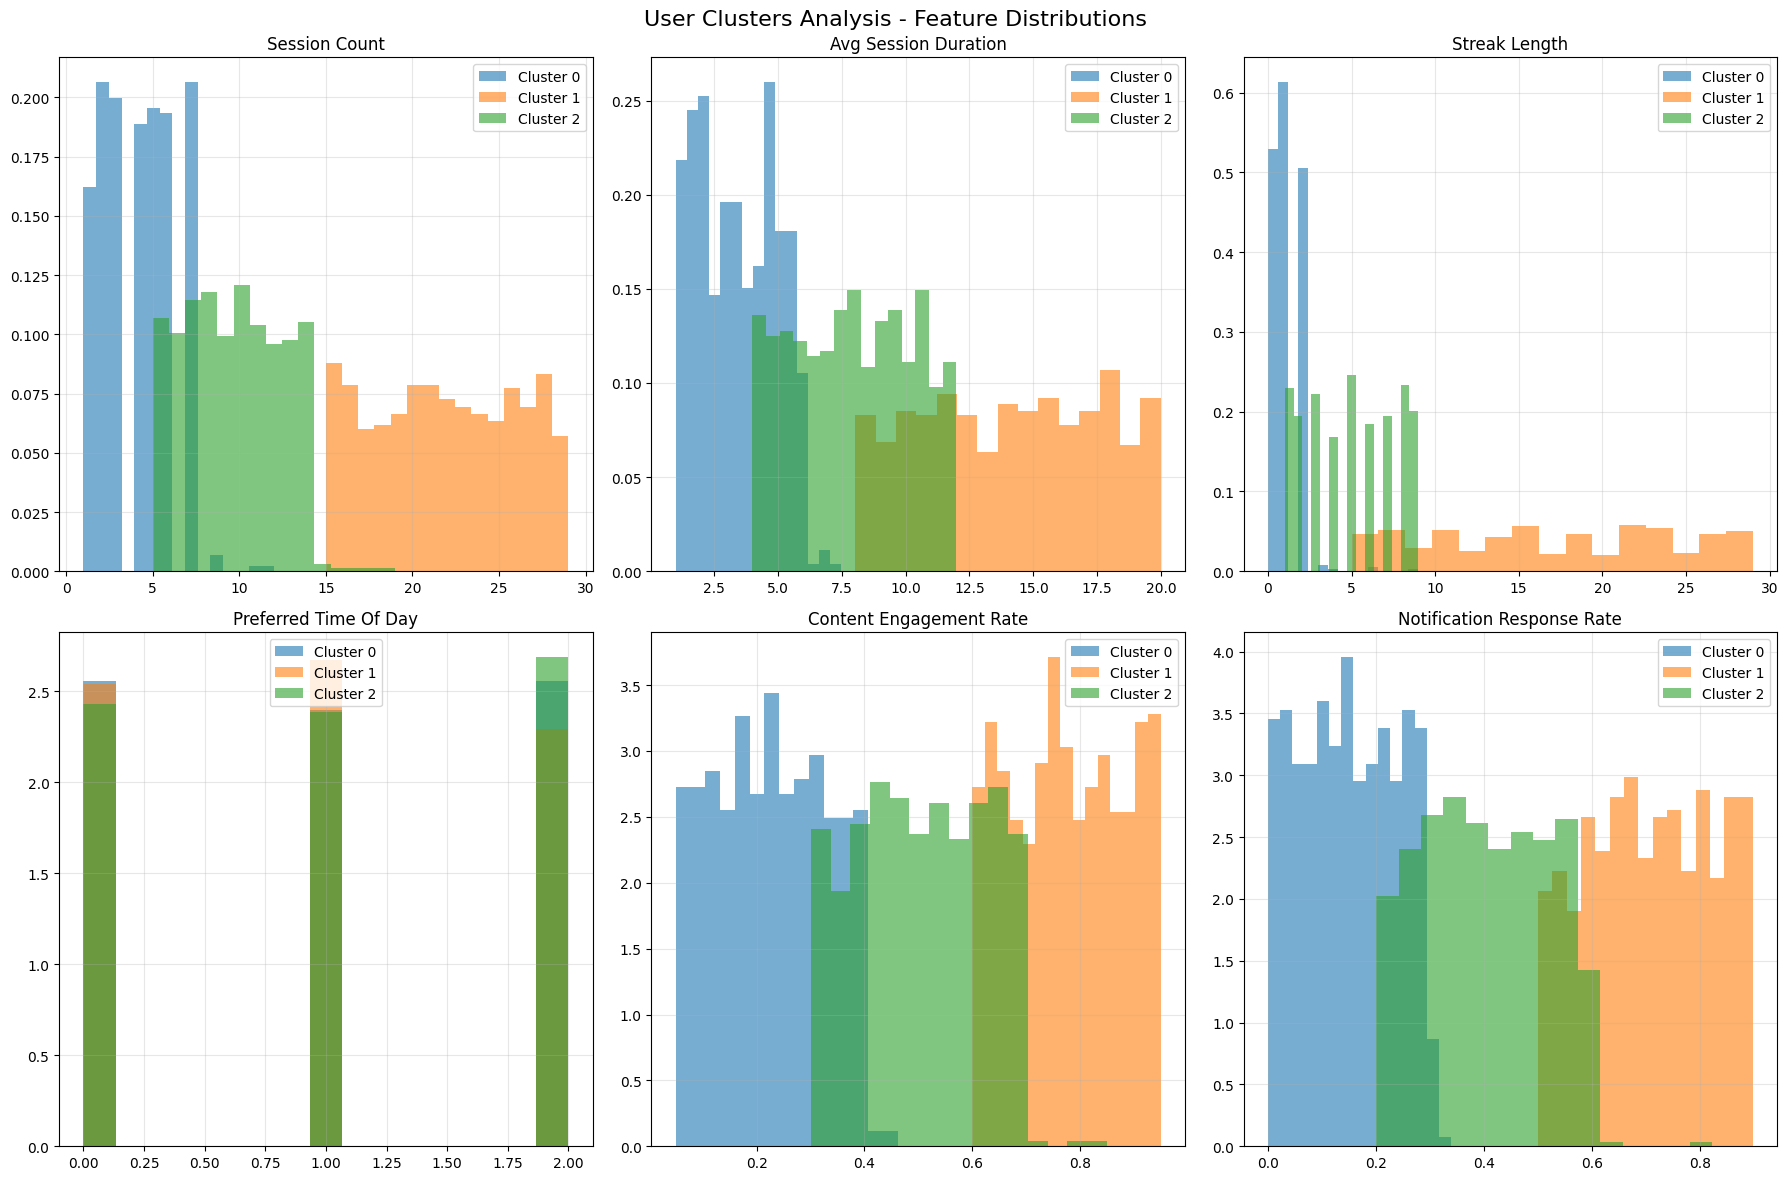

In [8]:
# Visualize clusters
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('User Clusters Analysis - Feature Distributions', fontsize=16)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot each feature by cluster
for i, feature in enumerate(clustering_features):
    row = i // 3
    col = i % 3
    
    for cluster_id in range(n_clusters):
        cluster_data = df[df['cluster'] == cluster_id][feature]
        axes[row, col].hist(cluster_data, alpha=0.6, label=f'Cluster {cluster_id}', 
                           color=colors[cluster_id], bins=15, density=True)
    
    axes[row, col].set_title(f'{feature.replace("_", " ").title()}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Create cluster names and descriptions based on behavior patterns
cluster_names = {}
cluster_descriptions = {}

print("=== Cluster Interpretation ===")

for cluster_id in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_id]
    
    # Calculate key metrics
    avg_engagement = cluster_data['content_engagement_rate'].mean()
    avg_sessions = cluster_data['session_count'].mean()
    avg_streak = cluster_data['streak_length'].mean()
    avg_duration = cluster_data['avg_session_duration'].mean()
    avg_notification_response = cluster_data['notification_response_rate'].mean()
    
    # Assign names based on behavior patterns
    if avg_engagement > 0.6 and avg_sessions > 15:
        cluster_names[cluster_id] = "Routine Builders"
        cluster_descriptions[cluster_id] = "Users who prefer structured, consistent wellness routines with high engagement"
    elif avg_sessions > 8 and avg_streak > 3:
        cluster_names[cluster_id] = "Explorers"
        cluster_descriptions[cluster_id] = "Users who like trying different activities and approaches with moderate consistency"
    else:
        cluster_names[cluster_id] = "Casual Check-ins"
        cluster_descriptions[cluster_id] = "Users who engage sporadically but show interest in wellness activities"
    
    print(f"\n🏷️  Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"   📝 {cluster_descriptions[cluster_id]}")
    print(f"   👥 Size: {len(cluster_data):,} users ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"   📊 Key metrics:")
    print(f"      • Sessions: {avg_sessions:.1f}")
    print(f"      • Duration: {avg_duration:.1f} min")
    print(f"      • Streak: {avg_streak:.1f} days")
    print(f"      • Engagement: {avg_engagement:.1%}")
    print(f"      • Notification response: {avg_notification_response:.1%}")

=== Cluster Interpretation ===

🏷️  Cluster 0: Casual Check-ins
   📝 Users who engage sporadically but show interest in wellness activities
   👥 Size: 614 users (30.7%)
   📊 Key metrics:
      • Sessions: 4.1
      • Duration: 3.4 min
      • Streak: 1.0 days
      • Engagement: 22.7%
      • Notification response: 15.0%

🏷️  Cluster 1: Routine Builders
   📝 Users who prefer structured, consistent wellness routines with high engagement
   👥 Size: 694 users (34.7%)
   📊 Key metrics:
      • Sessions: 21.9
      • Duration: 14.1 min
      • Streak: 17.0 days
      • Engagement: 77.6%
      • Notification response: 70.7%

🏷️  Cluster 2: Explorers
   📝 Users who like trying different activities and approaches with moderate consistency
   👥 Size: 692 users (34.6%)
   📊 Key metrics:
      • Sessions: 9.5
      • Duration: 7.9 min
      • Streak: 5.0 days
      • Engagement: 50.7%
      • Notification response: 40.4%


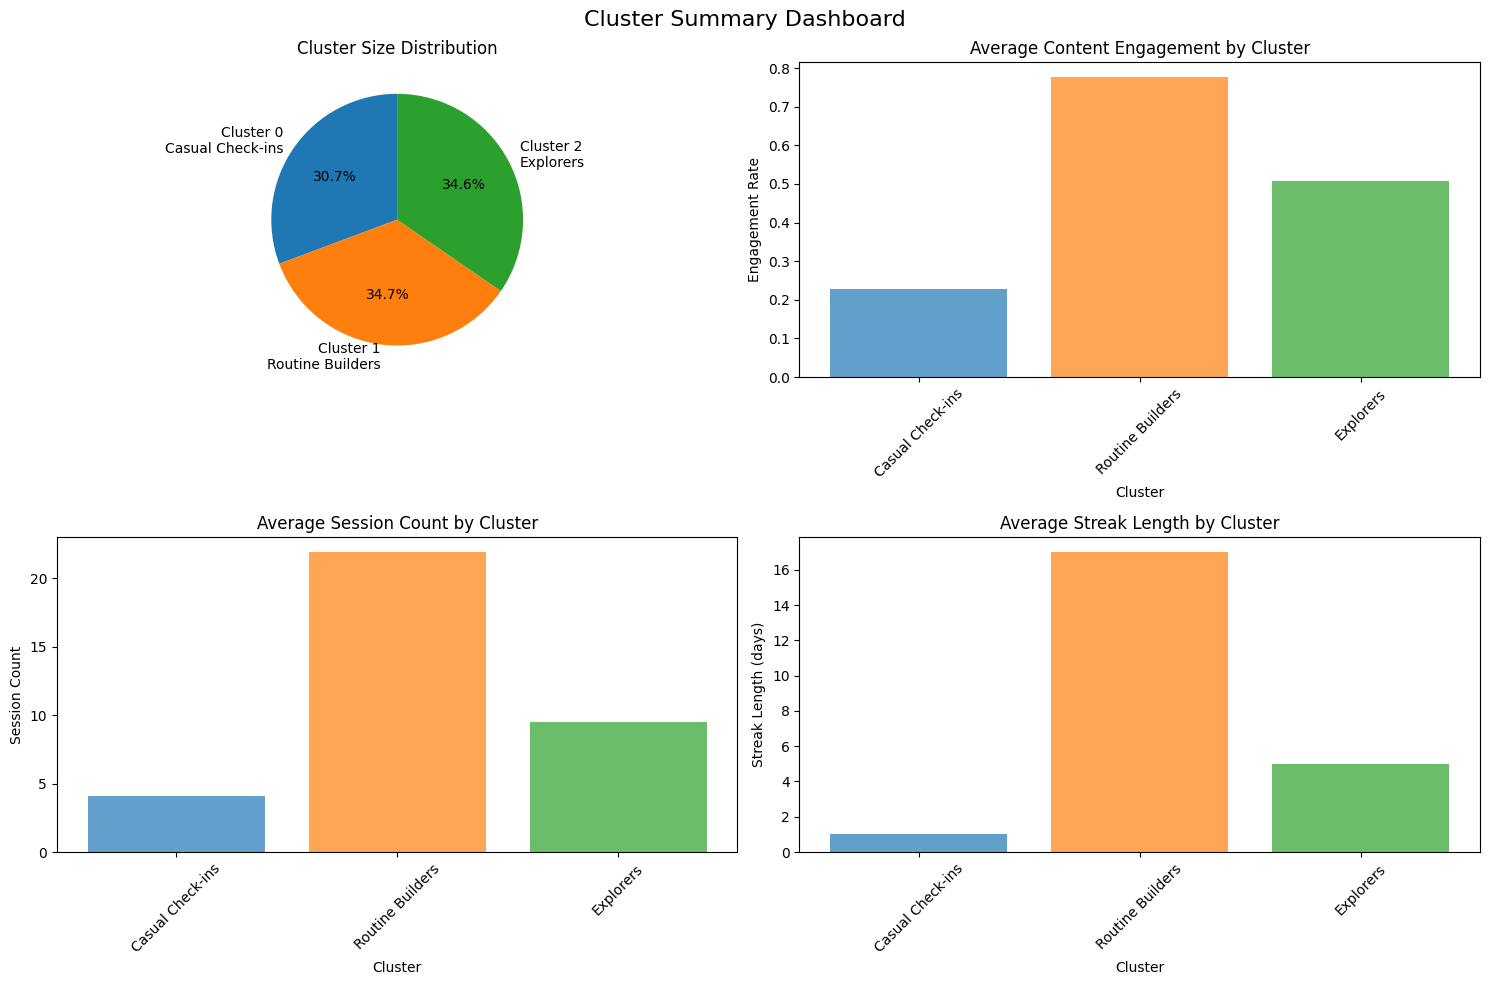

In [10]:
# Create cluster summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cluster Summary Dashboard', fontsize=16)

# Cluster sizes
cluster_sizes = df['cluster'].value_counts().sort_index()
cluster_labels = [f"Cluster {i}\n{cluster_names[i]}" for i in range(n_clusters)]
axes[0,0].pie(cluster_sizes.values, labels=cluster_labels, autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[0,0].set_title('Cluster Size Distribution')

# Average engagement by cluster
engagement_by_cluster = df.groupby('cluster')['content_engagement_rate'].mean()
bars1 = axes[0,1].bar(range(n_clusters), engagement_by_cluster.values, color=colors, alpha=0.7)
axes[0,1].set_title('Average Content Engagement by Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Engagement Rate')
axes[0,1].set_xticks(range(n_clusters))
axes[0,1].set_xticklabels([cluster_names[i] for i in range(n_clusters)], rotation=45)

# Session count by cluster
sessions_by_cluster = df.groupby('cluster')['session_count'].mean()
bars2 = axes[1,0].bar(range(n_clusters), sessions_by_cluster.values, color=colors, alpha=0.7)
axes[1,0].set_title('Average Session Count by Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Session Count')
axes[1,0].set_xticks(range(n_clusters))
axes[1,0].set_xticklabels([cluster_names[i] for i in range(n_clusters)], rotation=45)

# Streak length by cluster
streak_by_cluster = df.groupby('cluster')['streak_length'].mean()
bars3 = axes[1,1].bar(range(n_clusters), streak_by_cluster.values, color=colors, alpha=0.7)
axes[1,1].set_title('Average Streak Length by Cluster')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Streak Length (days)')
axes[1,1].set_xticks(range(n_clusters))
axes[1,1].set_xticklabels([cluster_names[i] for i in range(n_clusters)], rotation=45)

plt.tight_layout()
plt.show()

In [14]:
# Save the trained model and supporting data
ml_models_dir = "../ml_models/clustering"
os.makedirs(ml_models_dir, exist_ok=True)

# Save KMeans model
kmeans_path = os.path.join(ml_models_dir, "kmeans_model.joblib")
joblib.dump(kmeans_final, kmeans_path)
print(f"✅ Saved KMeans model to {kmeans_path}")

# Save cluster information (matching the application's expected structure)
cluster_info = {
    "clusters": {
        str(cluster_id): {
            "name": cluster_names[cluster_id],
            "description": cluster_descriptions[cluster_id]
        }
        for cluster_id in range(n_clusters)
    },
    "feature_names": clustering_features
}

cluster_info_path = os.path.join(ml_models_dir, "cluster_info.json")
with open(cluster_info_path, 'w') as f:
    json.dump(cluster_info, f, indent=2)
print(f"✅ Saved cluster info to {cluster_info_path}")

# Save scaler for future use
scaler_path = os.path.join(ml_models_dir, "clustering_scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"✅ Saved feature scaler to {scaler_path}")

print(f"\n🎉 User clustering model training completed successfully!")
print(f"\n📁 Files created:")
print(f"   • {kmeans_path}")
print(f"   • {cluster_info_path}")
print(f"   • {scaler_path}")

print(f"\n📈 Model Summary:")
print(f"   • Algorithm: KMeans with {n_clusters} clusters")
print(f"   • Features: {len(clustering_features)} behavioral features")
print(f"   • Inertia: {kmeans_final.inertia_:.2f}")
print(f"   • Training samples: {len(df):,} users")

✅ Saved KMeans model to ../ml_models/clustering/kmeans_model.joblib
✅ Saved cluster info to ../ml_models/clustering/cluster_info.json
✅ Saved feature scaler to ../ml_models/clustering/clustering_scaler.joblib

🎉 User clustering model training completed successfully!

📁 Files created:
   • ../ml_models/clustering/kmeans_model.joblib
   • ../ml_models/clustering/cluster_info.json
   • ../ml_models/clustering/clustering_scaler.joblib

📈 Model Summary:
   • Algorithm: KMeans with 3 clusters
   • Features: 6 behavioral features
   • Inertia: 4201.86
   • Training samples: 2,000 users


In [ ]:
# Test the saved model
print("=== Testing Saved Model ===")

# Load the model
loaded_kmeans = joblib.load(kmeans_path)
loaded_scaler = joblib.load(scaler_path)
with open(cluster_info_path, 'r') as f:
    loaded_cluster_info = json.load(f)

print("✅ All models loaded successfully")

# Test with sample user data (matching the expected API format)
test_user = {
    "session_count": 12,
    "avg_session_duration": 8.5,
    "streak_length": 5,
    "preferred_time_of_day": 0,  # Morning
    "content_engagement_rate": 0.75,
    "notification_response_rate": 0.6
}

# Prepare features (simulate FeaturePreparator logic)
test_features = np.array([
    test_user["session_count"],
    test_user["avg_session_duration"],
    test_user["streak_length"],
    test_user["preferred_time_of_day"],
    test_user["content_engagement_rate"],
    test_user["notification_response_rate"]
]).reshape(1, -1)

# Scale features
test_features_scaled = loaded_scaler.transform(test_features)

# Make prediction
cluster_prediction = loaded_kmeans.predict(test_features_scaled)[0]
cluster_name = loaded_cluster_info["clusters"][str(cluster_prediction)]["name"]
cluster_description = loaded_cluster_info["clusters"][str(cluster_prediction)]["description"]

print(f"\n🧪 Test User Clustering:")
print(f"   Input features: {test_user}")
print(f"   Predicted cluster: {cluster_prediction} - {cluster_name}")
print(f"   Description: {cluster_description}")

print(f"\n✅ Model is working correctly and ready for production use!")